In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simple-loan-classification-dataset/loan.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [3]:
path = '/kaggle/input/simple-loan-classification-dataset/loan.csv'

df = pd.read_csv(path)

df

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved
...,...,...,...,...,...,...,...,...
56,39,Male,Architect,Master's,Married,100000,770,Approved
57,25,Female,Receptionist,High School,Single,32000,570,Denied
58,43,Male,Banker,Bachelor's,Married,95000,760,Approved
59,30,Female,Writer,Master's,Single,55000,650,Approved


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              61 non-null     int64 
 1   gender           61 non-null     object
 2   occupation       61 non-null     object
 3   education_level  61 non-null     object
 4   marital_status   61 non-null     object
 5   income           61 non-null     int64 
 6   credit_score     61 non-null     int64 
 7   loan_status      61 non-null     object
dtypes: int64(3), object(5)
memory usage: 3.9+ KB


In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,0,0,0,0,0,0,0,0


In [6]:
df.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
age,61.000000,37.081967,8.424755,24.000000,24.000000,30.000000,31.000000,36.000000,43.000000,45.000000,55.000000,55.000000
income,61.000000,78983.606557,33772.025802,25000.000000,25000.000000,52000.000000,58000.000000,78000.000000,98000.000000,105000.000000,180000.000000,180000.000000
credit_score,61.000000,709.836066,72.674888,560.000000,560.000000,650.000000,670.000000,720.000000,770.000000,780.000000,830.000000,830.000000


In [7]:
df.describe()

,age,income,credit_score
count,61.000000,61.000000,61.000000
mean,37.081967,78983.606557,709.836066
std,8.424755,33772.025802,72.674888
min,24.000000,25000.000000,560.000000
25%,30.000000,52000.000000,650.000000
50%,36.000000,78000.000000,720.000000
75%,43.000000,98000.000000,770.000000
max,55.000000,180000.000000,830.000000


In [8]:
target = 'loan_status'

cont_cols = df.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = df.select_dtypes(object).columns


#other_categorics = ['feature1','feature2','feature3','feature4','feature5']

obj_cols = obj_cols.tolist() 

# Convert cont_cols to a list and remove any columns that are in obj_cols
cont_cols = cont_cols.tolist()
cont_cols = [col for col in cont_cols if col not in obj_cols]

len(cont_cols), len(obj_cols)
print(f'Object cols: {obj_cols}')
print(f'Continuous Cols: {cont_cols}')

Object cols: ['gender', 'occupation', 'education_level', 'marital_status', 'loan_status']
Continuous Cols: ['age', 'income', 'credit_score']


In [9]:
def mPlotter(r, c, size, _targets, text):
    
    bg = '#010108'
    
    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']
    
    font = 'Comic Sans MS'
    
    fig = plt.figure(figsize=size)
    
    fig.patch.set_facecolor(bg)
    
    grid = fig.add_gridspec(r, c)
    
    grid.update(wspace=0.5, hspace=0.25)
    
    __empty_diff = ((r * c) - 1) - len(_targets)
        
    axes = []
    
    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))
    
    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg) 
        
        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18, 
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]
        
    return axes, palette, cb

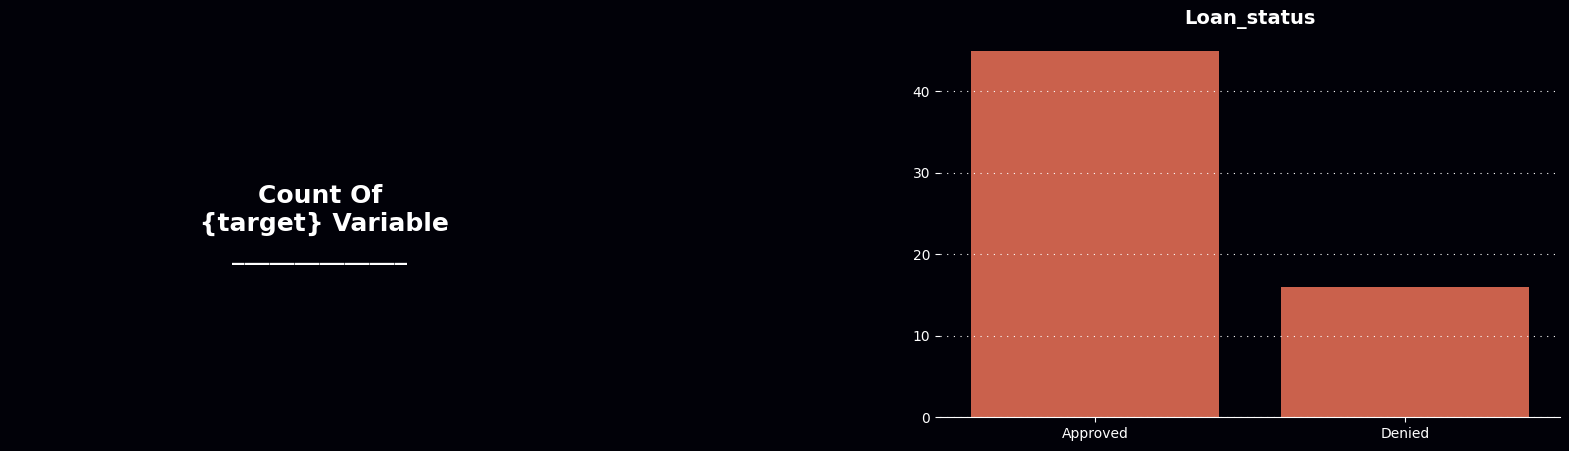

In [10]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\n {target} Variable\n______________')

sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

/tmp/ipykernel_17/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_17/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
/tmp/ipykernel_17/1820082286.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)


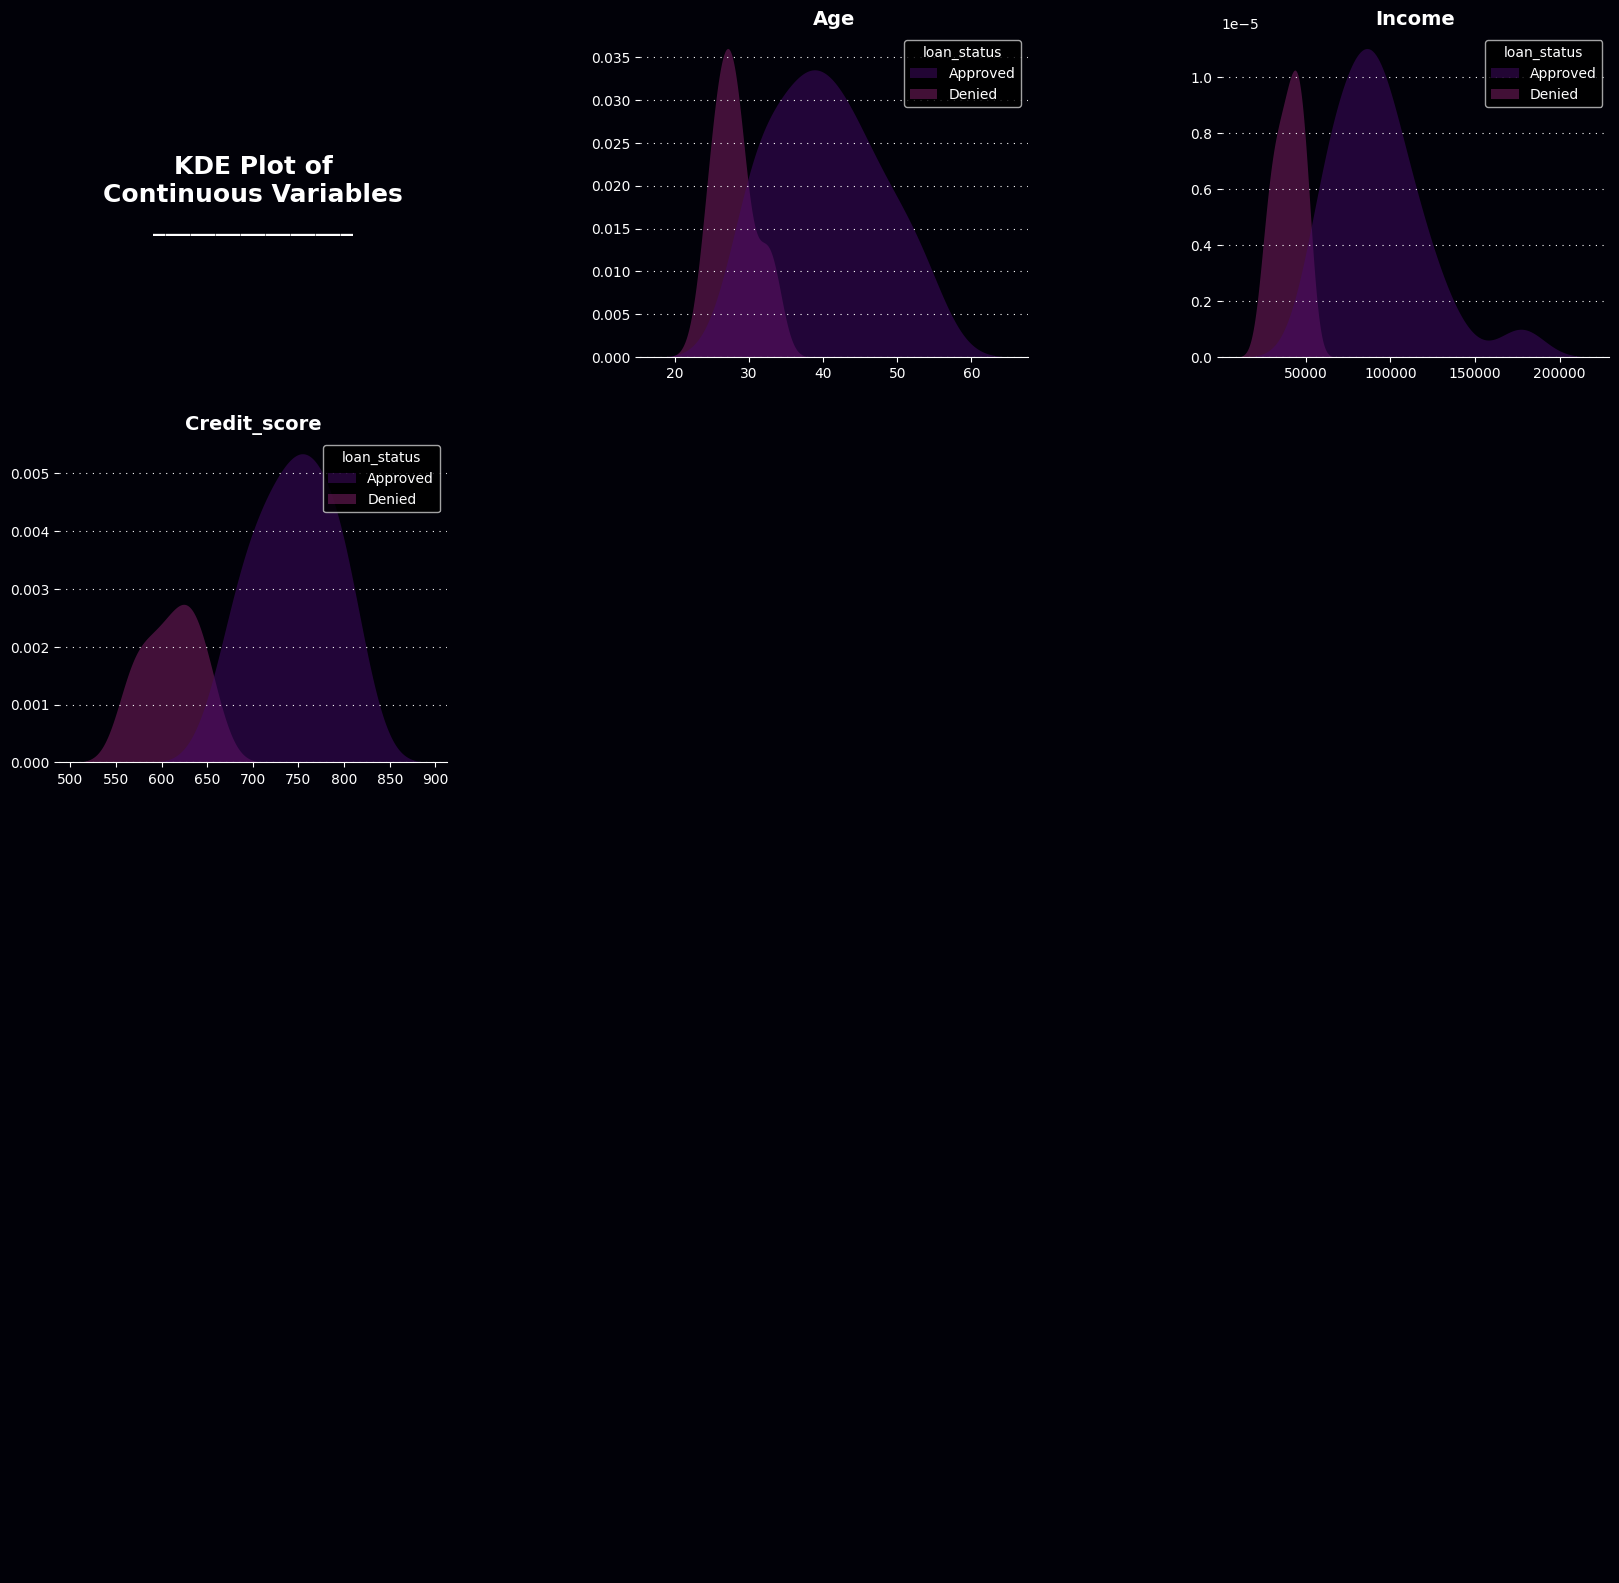

In [11]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

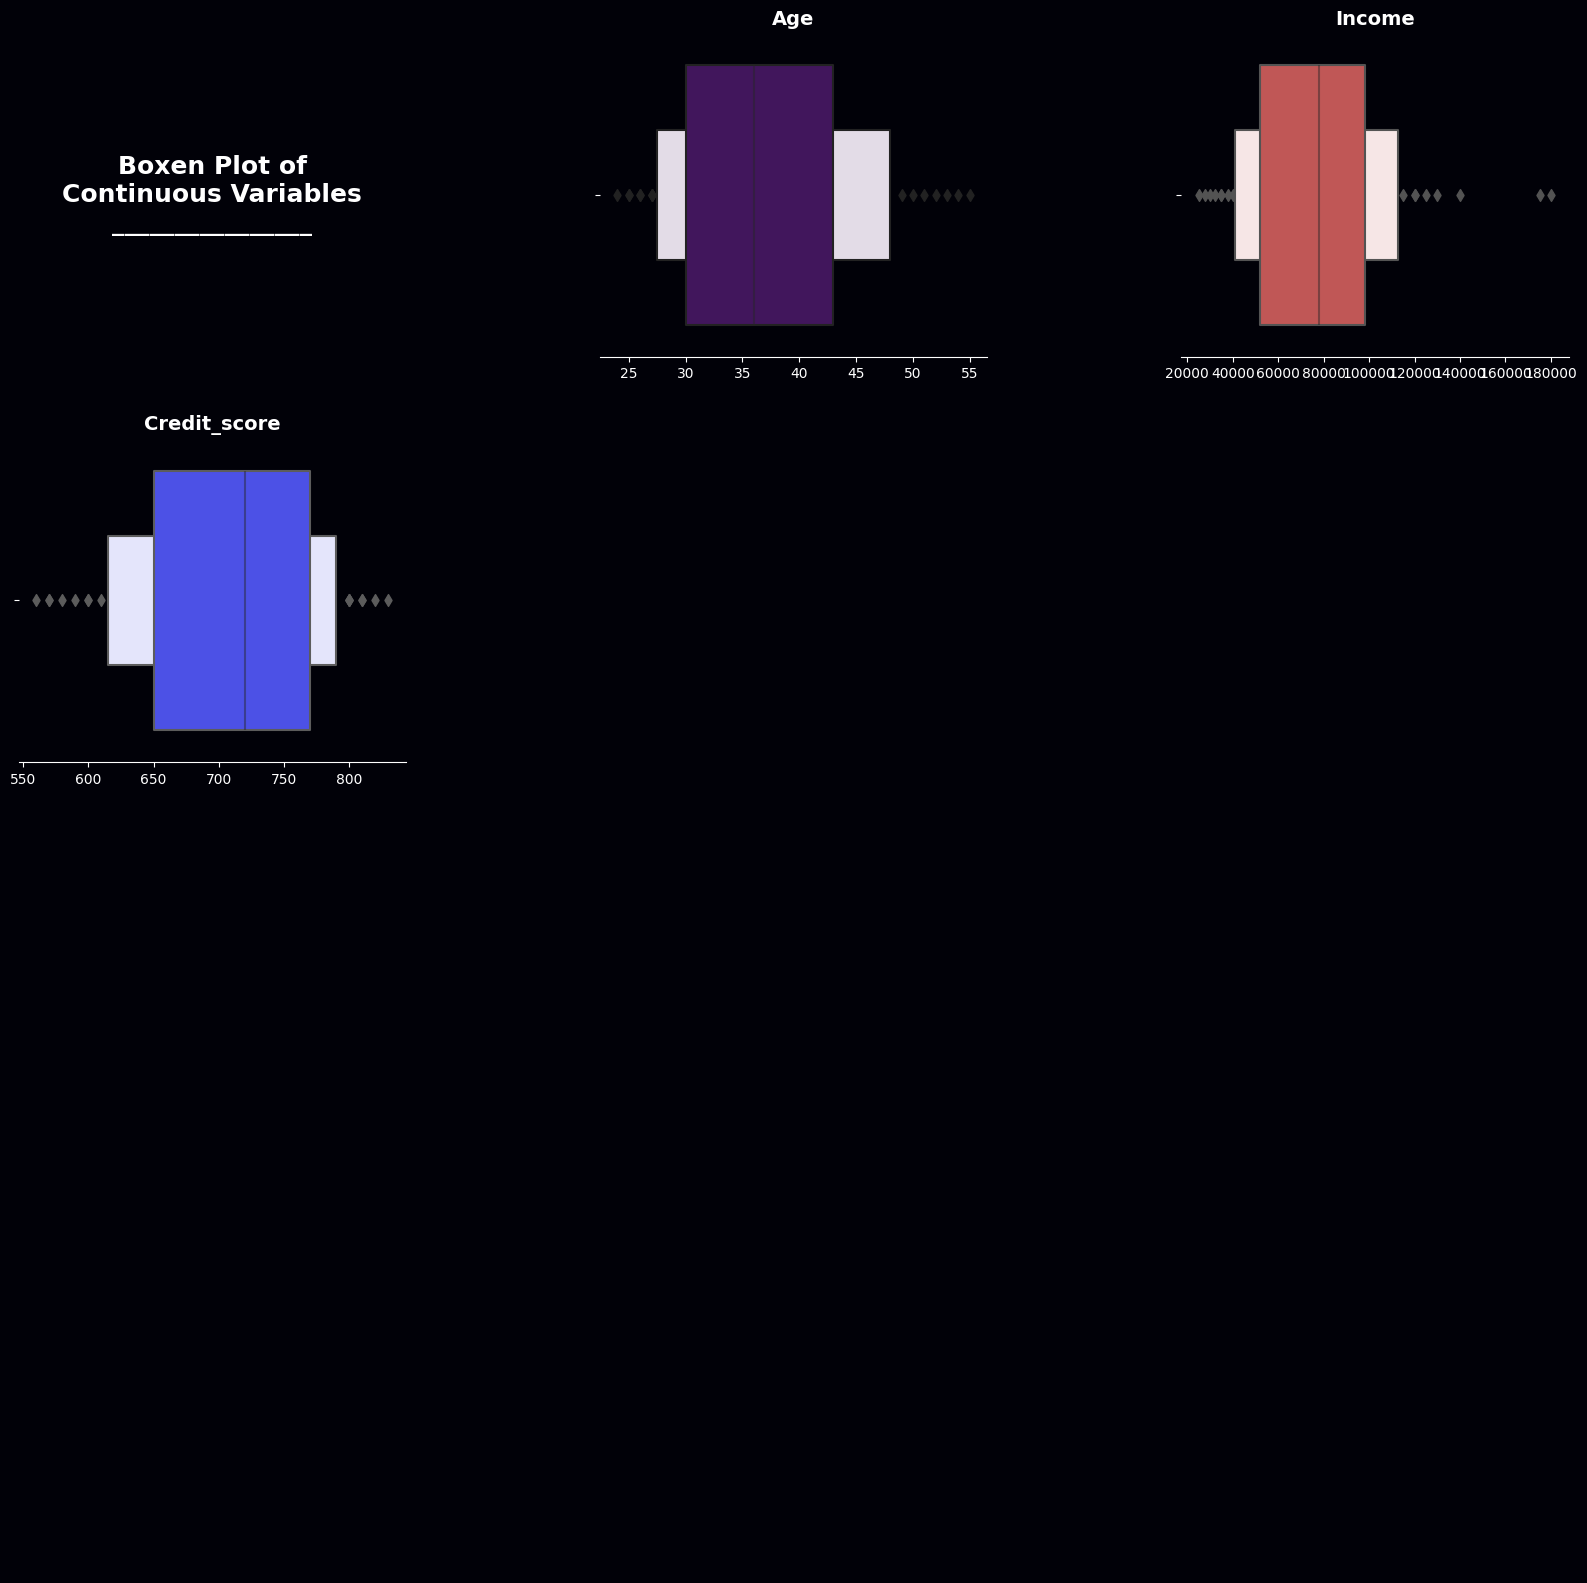

In [12]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

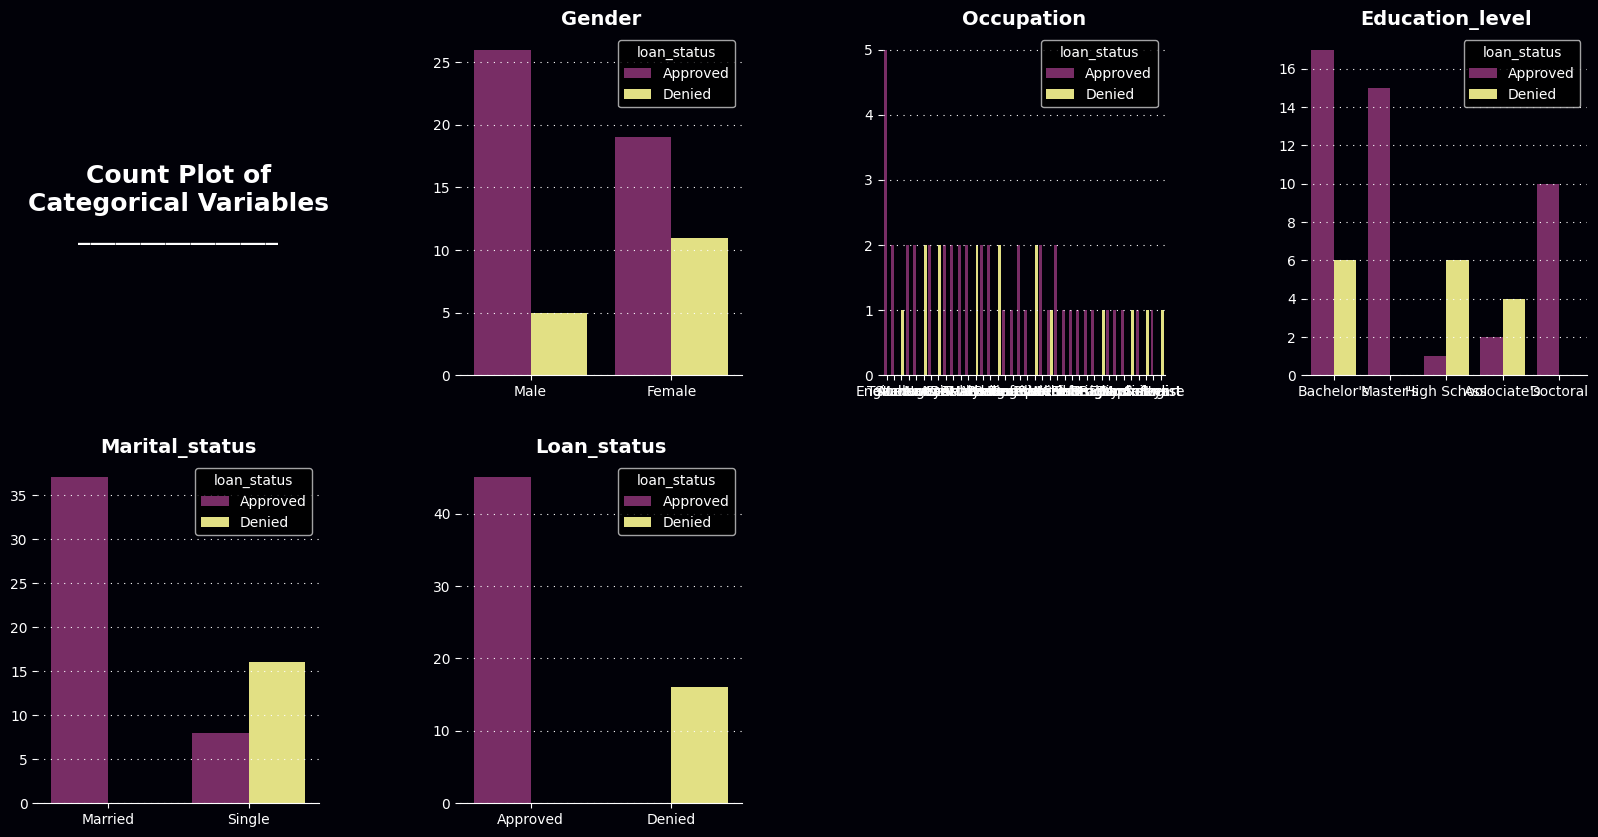

In [13]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=df, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

In [14]:
ax = px.scatter_3d(df, x="age", y="income", z="credit_score", template= "plotly_dark", color=target, title="3D Scatter Plot of Continuous Variables")

ax.show()

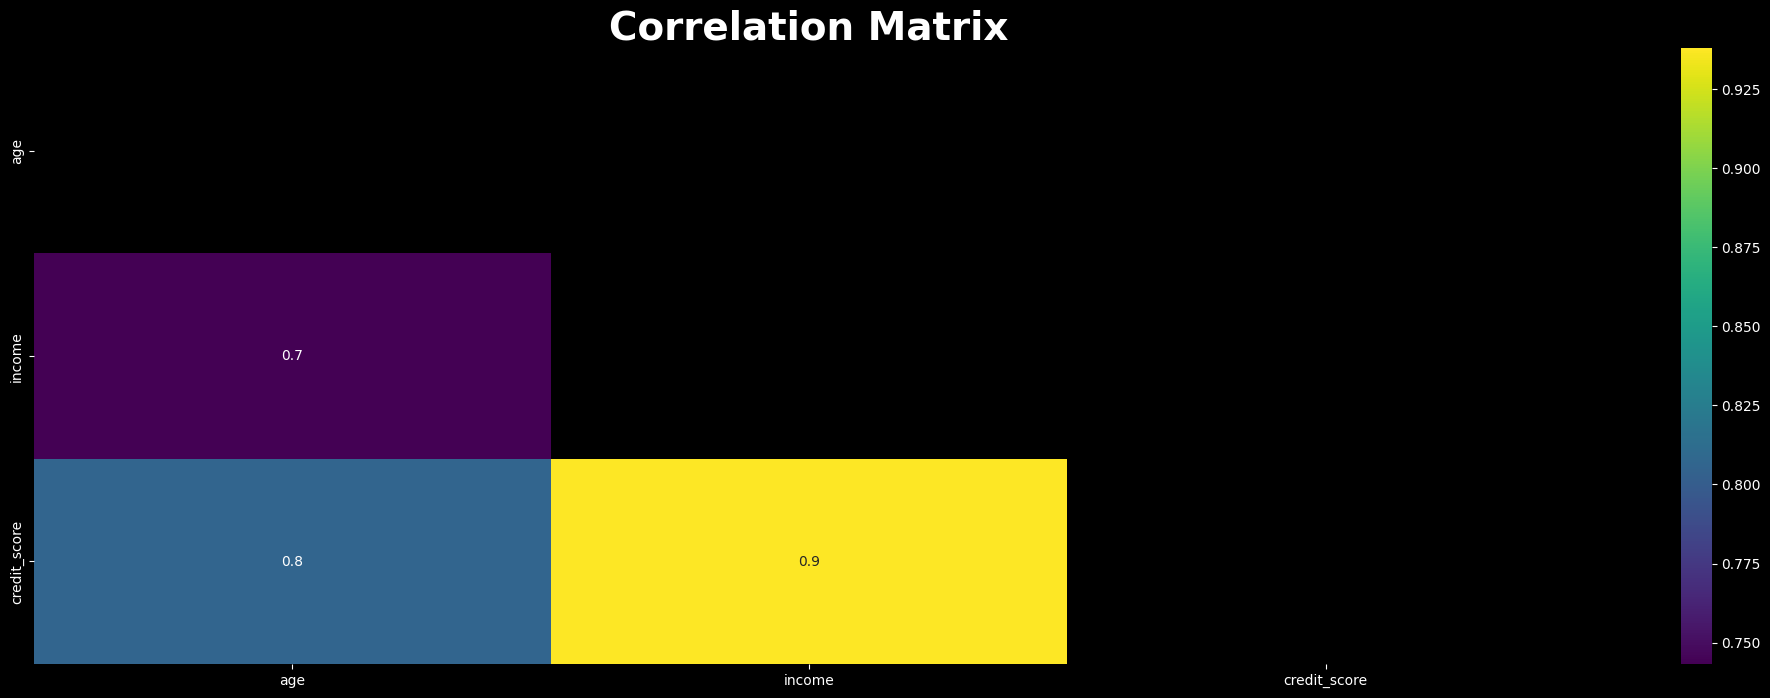

In [15]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='viridis')

plt.show()

In [16]:
for col in df.select_dtypes(object):
    df[col] = LabelEncoder().fit_transform(df[col])
    
df

,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,1,12,1,0,85000,720,0
1,45,0,35,4,1,62000,680,0
2,28,1,33,3,1,25000,590,1
3,51,0,16,1,0,105000,780,0
4,36,1,0,1,0,75000,710,0
...,...,...,...,...,...,...,...,...
56,39,1,2,4,0,100000,770,0
57,25,0,27,3,1,32000,570,1
58,43,1,4,1,0,95000,760,0
59,30,0,37,4,1,55000,650,0


In [17]:
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

In [18]:
X = df.drop(columns=[target], axis=1)
y = df[target].values

In [19]:
X.head()

,age,gender,occupation,education_level,marital_status,income,credit_score
0,32,1,12,1,0,85000,720
1,45,0,35,4,1,62000,680
2,28,1,33,3,1,25000,590
3,51,0,16,1,0,105000,780
4,36,1,0,1,0,75000,710


In [20]:
y

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42, 7), (19, 7), (42,), (19,))

In [22]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'KNN': KNeighborsClassifier(),
    #'Neural Network': MLPClassifier(),
    #'LGBM': LGBMClassifier(),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(verbose=0)), 
            ('xg', XGBClassifier()), 
            ('lgbm', LGBMClassifier(verbose=-1))],
    voting='soft',
    verbose=False
)
}


params={
    'Logistic Regression': {'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [200]},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'Random Forest': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'KNN': {'n_neighbors': [3, 5, 7, 9 , 13], 'weights': ['uniform', 'distance']},
    'Naive Bayes': { 'var_smoothing': [1e-9, 1e-8, 1e-7]},
    'Neural Network': {'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)], 
                       'activation': ['logistic', 'tanh', 'relu'],
                       'solver': ['adam'], 'alpha': [0.0001, 0.001, 0.01],
                       'max_iter': [ 500, 1000,2000]},
    'XGBoost': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'LGBM': {'n_estimators': [100, 300, 500], 'max_depth': [3, 5, 7, 9, 11, 13]},
    'CatBoost': {'iterations': [100, 300, 500], 'depth': [3, 5, 7, 9, 11, 13]},
    'Voting Classifier': {}
}

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score , f1_score ,classification_report

# Train function
def train_model(X_train, y_train, models, params):
    best_estimators = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=params[model_name],
            scoring='accuracy',
            cv=5, n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        best_estimators[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")
    return best_estimators

# Evaluate function
def evaluate_model(X_test, y_test, models):
    classification_reports = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

       

        classification_rep = classification_report(y_test, y_pred)

       

        classification_reports[model_name] = classification_rep

    return  classification_reports

In [25]:
# Train the models
best_models = train_model(X_train, y_train, models, params)

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'max_iter': 200, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9305555555555556

Training Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3}
Best score for Decision Tree: 0.975

Training Random Forest...
Best parameters for Random Forest: {'max_depth': 3, 'n_estimators': 100}
Best score for Random Forest: 0.975

Training Naive Bayes...
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best score for Naive Bayes: 0.9027777777777779

Training XGBoost...
Best parameters for XGBoost: {'max_depth': 3, 'n_estimators': 100}
Best score for XGBoost: 0.975

Training CatBoost...
Best parameters for CatBoost: {'depth': 3, 'iterations': 100}
Best score for CatBoost: 0.975

Training KNN...
Best parameters for KNN: {'n_neighbors': 13, 'weights': 'uniform'}
Best score for KNN: 0.9055555555555556

Training Voting Classifier...
Best parameters for Voting Classi

In [26]:
# Evaluate the best models
classification_reports = evaluate_model(X_test, y_test, best_models)

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Naive Bayes...
Evaluating XGBoost...
Evaluating CatBoost...
Evaluating KNN...
Evaluating Voting Classifier...


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Print classification reports
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.80      1.00      0.89         4

    accuracy                           0.95        19
   macro avg       0.90      0.97      0.93        19
weighted avg       0.96      0.95      0.95        19


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         4

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         4

    accuracy                           1.00       